### Multi-model DP using Advantage function

In [1]:
import torch
import numpy as np
import sys
sys.path.append('../')
from robust_tt import RTT
from dyn_models.dynamic_systems_mm import Reorientation3
import numpy as np
from tt_utils import contract_sites

%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:

dt=0.01
T = 10

state_max = torch.tensor([1.1*torch.pi,5*torch.pi]).to(device) # (theta,dtheta)
state_min = torch.tensor([0,0]).to(device)
# state_max = torch.tensor([1.1*torch.pi,4*torch.pi]).to(device) # (theta,dtheta)
# state_min = -1*state_max

n_state = 50
n_param = 100
n_action = 50

mass = 1.0; length=0.5; g= 9.81; coef_viscous = 0.1

dtheta_init = torch.tensor([torch.pi*2]).to(device) # Initial angular velocity given by hand

param_min = torch.tensor([0.2, 0.15, 0.2]).to(device) # mass, length, torsional friction coefficient
param_max = torch.tensor([1.0, 0.4, 1.0]).to(device)
action_max = 4*mass*g*length 
action_max = torch.tensor([action_max]).to(device) # normal force
action_min = torch.tensor([0]).to(device)

In [4]:
domain_state = [torch.linspace(state_min[i],state_max[i],n_state).to(device) for i in range(len(state_max))]
domain_param = [torch.linspace(param_min[i],param_max[i],n_param).to(device) for i in range(3)]
domain_state_param = domain_state + domain_param

domain_action = [torch.linspace(action_min[i],action_max[i],n_action).to(device) for i in range(len(action_max))]
domain_state_action  = domain_state + domain_action

In [5]:
w_goal=1.0
w_action=0.01
w_scale = 1
sys = Reorientation3(state_min=state_min, state_max=state_max, action_max=action_max, action_min=action_min, dt=dt, w_scale=w_scale, w_goal=w_goal, w_action=w_action, device=device)



In [6]:
def forward_model(state_param,action):
    return sys.forward_simulate(state_param,action)

def reward(state_param,action):
    rewards = sys.reward_state_action(state_param,action)
    return rewards



In [7]:
n_test = 100
dim_state = len(domain_state)
init_state = torch.zeros((n_test,dim_state))
for i in range(dim_state):
    init_state[:,i] = state_min[i] + torch.rand(n_test).clip(0.0,0.75).to(device)*(state_max[i]-state_min[i])
state = init_state.to(device)
# state[:, 0] = torch.rand(n_test).to(device)*(state_max[0])
state[0, 0] = torch.zeros_like(state[0, 0])
state[:, 1] = torch.ones_like(state[:, 1])*(state_max[1])


In [8]:
tol = torch.tensor([5/180*torch.pi, 5/180*torch.pi]).to(device)[:2]
def callback(rtt, state=state, T=0.5, animation=False, file_name='file', callback_count=0):
    print("Testing....")

    traj = state.clone().view(1,-1,2) # time x sample x 2
    T=int(T/dt)
    cum_reward = torch.tensor([0.]*state.shape[0]).to(device)
    param  = torch.tensor([0.9, 0.3, 0.9]).view(1,-1).expand(state.shape[0],-1).to(device)
  
    state_param = torch.cat((state,param),dim=-1)
    for i in range(T):
        action = rtt.policy(state_param)
        r = rtt.reward_normalized(state_param,action)#reward_test(state,action)
        cum_reward+=r#reward_test(state,action)
        state_param = forward_model(state_param,action)
        traj = torch.concat((traj,state_param[:,:2].view(1,-1,2)),dim=0)
    final_state = state_param[:, :2]    
    print(final_state[:,0])
    
    theta_t = traj[:,0,0]
    import matplotlib.pyplot as plt0
    from plot_utils import plt_pendulum
    plt=plt_pendulum(theta_t.to('cpu').numpy(), figsize=5, dt=dt, scale=10, skip=10, animation=animation)
    plt.show()
    total_reward = torch.mean(cum_reward)
    return r.mean().to('cpu'), total_reward.to('cpu')
    

In [9]:
rtt = RTT(domain_state=domain_state_param, domain_action=domain_action, domain_param=domain_param, reward=reward, 
                forward_model=forward_model, gamma=0.999, n_steps=1,
                rmax_v=100, rmax_a=100, nswp_v=10, nswp_a=10, 
                kickrank_v=10, kickrank_a=10,
                max_batch_v=10**4,max_batch_a=10**5,
                eps_cross_v=1e-3, 
                eps_cross_a=1e-3,
                eps_round_v=1e-3, 
                eps_round_a=1e-3, 
                n_samples=1, normalize_reward=False,
                verbose=True,
                device=device) # action = 'deterministic_tt', 'stochastic_tt', 'random'

#############################################################################
Learning begins
#############################################################################
Computing reward function in TT format for normalization
cross device is cuda
Cross-approximation over a 6D domain containing 1.25e+11 grid points:
iter: 0  | eps: 4.049e-04 | time:   0.8080 | largest rank:   1
iter: 1  | eps: 1.215e-15 | time:   0.8402 | largest rank:  11 <- converged: eps < 0.0001
Did 87200 function evaluations, which took 0.005181s (1.683e+07 evals/s)

Rank of reward:  tensor([1, 2, 2, 2, 2, 2, 1])
Initialize policy (q-fcn) by random initialization of value-function....
Testing....
tensor([3.455752, 3.455752, 3.455752, 3.455752, 3.455752, 3.455752, 3.455752,
        3.455752, 3.455752, 3.455752, 3.455752, 3.455752, 3.455752, 3.455752,
        3.455752, 3.455752, 3.455752, 3.455752, 3.455752, 3.455752, 3.455752,
        3.455752, 3.455752, 3.455752, 3.455752, 3.455752, 3.455752, 3.455752,
        3

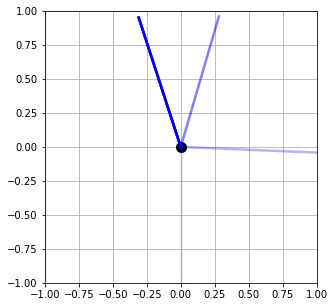

Memory:  0.000177664 0.236978176
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Policy Iteration 1/5
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Number of value updates:  1
.....................................................
Computing Advantage Fcn
.....................................................
v_min: -314.16, v_mean: -144.83, v_max: -3.21
a_min: -31441.65, a_mean: -13869.10, a_max: -307.27
p_min: 31135.38, p_mean: 48707.94, p_max: 62269.77
Rank of V-model:  tensor([1, 1, 1, 1, 1, 1])
Rank of A-model:  tensor([1, 3, 1, 1, 1, 1, 1])
Rank of P-model:  tensor([1, 5, 3, 3, 3, 3, 1])
--------------------------------------------
Time taken:0.29059720039367676
--------------------------------------------
Memory:  0.000142848 0.006291456000000001
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Policy Iteration 2/5
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Number of value updates:  1
.....................................................
Computing Advantage Fcn
..................................

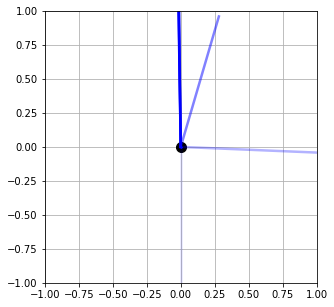

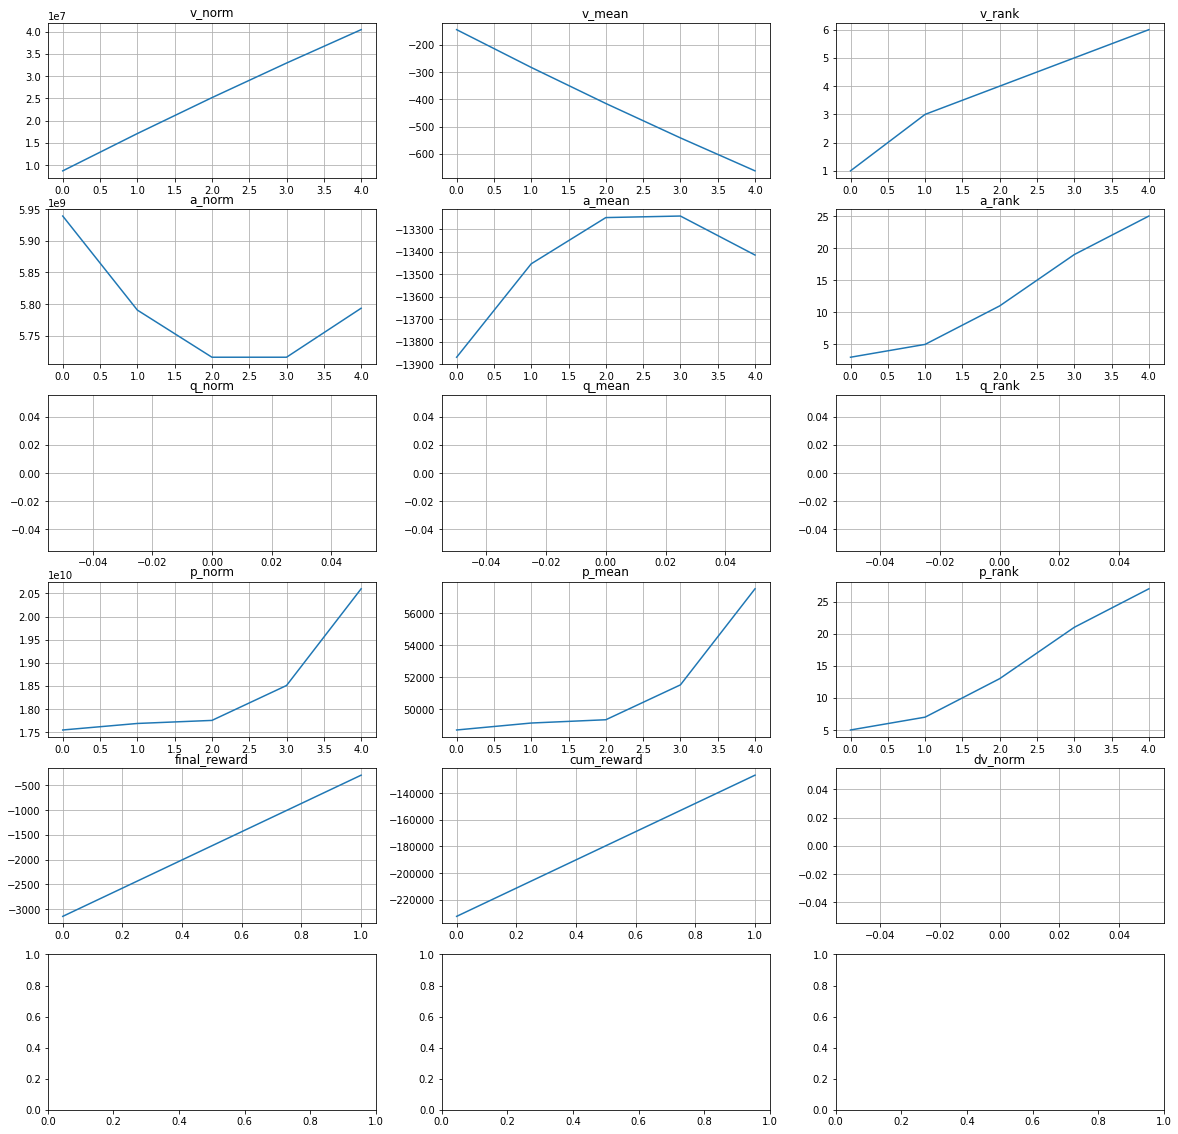

In [10]:
rtt.train(n_iter_max=5,n_iter_v=1,
        callback=callback, callback_freq=5,
        verbose=False, file_name='reorientation_test')